## Load Libraries

In [1]:
import torch
from torch import nn
from torch import optim
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [2]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

#make sure the model runs and backpropogates deterministically
torch.backends.cudnn.deterministic = True

In [3]:
# To use GPU 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
L1_LAMBDA = 100
EPOCHS = 300
learning_rate = 2e-4
IMG_SIZE = 256
BATCH_SIZE = 16

## Create Dataset and DataLoaders

In [5]:
# pretrained_size = 256
# pretrained_means = [0.5, 0.5, 0.5]
# pretrained_stds= [0.5, 0.5, 0.5]


# #resize images , add random noise and normalise after converting to tensors
# both_transforms = transforms.Compose([
#     transforms.Resize(pretrained_size),
# #     transforms.RandomHorizontalFlip(0.5),
#     transforms.ToTensor(),
# ])

# input_transforms = transforms.Compose([
#     transforms.ColorJitter(0.5),
#     transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
# ])

In [6]:
both_transform = A.Compose([
    A.Resize(
        width=IMG_SIZE, 
        height=IMG_SIZE
    ),
    A.HorizontalFlip(p=0.5)], 
    additional_targets={"image0": "image"},
)

transform_only_input = A.Compose([
    A.ColorJitter(p=0.2),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
    ToTensorV2(),
])

transform_only_label = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
    ToTensorV2(),
])

In [7]:
class MapDataset(Dataset):
    def __init__(self, dir_name):
        self.dir_name = dir_name
        self.list_files = os.listdir(self.dir_name)
        print("Total images: ", len(self.list_files))

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.dir_name, img_file)
        image = np.array(Image.open(img_path))
        input_img = image[:, :600, :]
        target_img = image[:, 600:, :]

#         input_img, target_img = both_transforms(image = input_img, image0 = target_img)
#         input_img = input_transforms(image = input_img)
#         input_img, target_img = both_transforms(input_img), both_transforms(target_img)
#         input_img = input_transforms(input_img)
    
#         input_img = input_img.to(torch.float32)
#         target_img = target_img.to(torch.float32)

        augmentations = both_transform(image = input_img, image0 = target_img)
        input_img, target_img = augmentations["image"], augmentations["image0"]
        
        input_img = transform_only_input(image = input_img)["image"]
        target_img = transform_only_input(image = target_img)["image"]
        
#         input_img = torch.from_numpy(input_img).to(torch.float32)
#         target_img = torch.from_numpy(target_img).to(torch.float32)
        
        return input_img, target_img

In [8]:
train_dataset = MapDataset(dir_name = "/kaggle/input/pix2pix-dataset/maps/maps/train")
val_dataset = MapDataset(dir_name = "/kaggle/input/pix2pix-dataset/maps/maps/val")

trainloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
valloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

Total images:  1096
Total images:  1098


  0%|          | 0/69 [00:00<?, ?it/s]

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


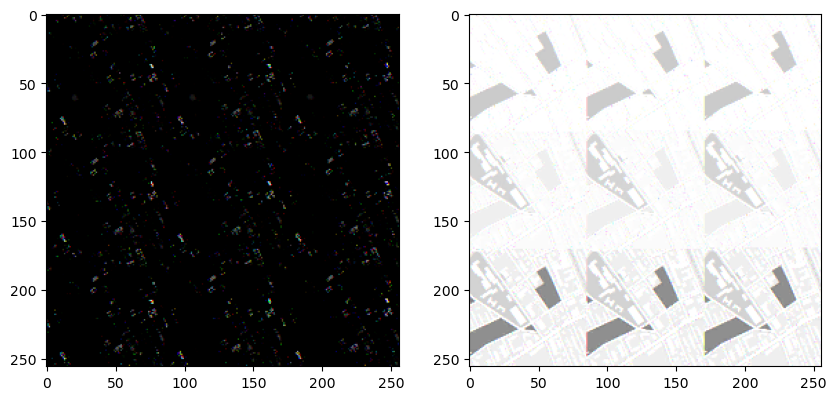

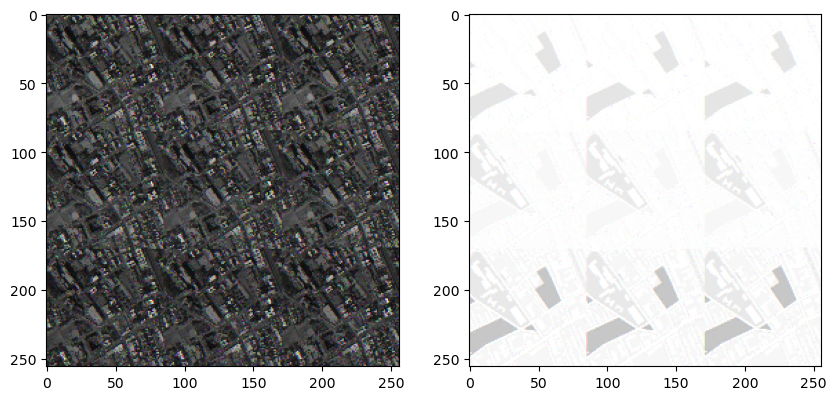

  0%|          | 0/69 [00:02<?, ?it/s]


In [9]:
for X, Y in tqdm(trainloader, leave=True, position=0):
    A,B = X[0], Y[0] 
    print(X.shape, Y.shape)  
    plt.figure(figsize = (10, 8))
    plt.subplot(1,2,1)
    plt.imshow(X[0].reshape(256, 256, 3))
    plt.subplot(1,2,2)
    plt.imshow(Y[0].reshape(256, 256, 3))
    plt.show()
    
    X = X * 0.5 + 0.5
    Y = Y * 0.5 + 0.5
    plt.figure(figsize = (10, 8))
    plt.subplot(1,2,1)
    plt.imshow(X[0].reshape(256, 256, 3))
    plt.subplot(1,2,2)
    plt.imshow(Y[0].reshape(256, 256, 3))
    plt.show()
    
    break

## Create Generator and Discriminator

In [10]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 2):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = stride, bias = False, padding_mode = "reflect"),
            # no need for bias since we are using BatchNorm2D
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        return self.conv(x)

In [11]:
features = [64, 128, 256, 512]
features[1: -1]

[128, 256]

In [12]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            # 2 * in_channels since it is taking 2 images
            nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:-1]:
            layers.append(
                CNNBlock(in_channels = in_channels, out_channels = feature, stride = 2)
            )
            in_channels = feature
        
        layers.append(
            CNNBlock(in_channels, features[-1], stride = 1)
        )
        
        layers.append(
            nn.Conv2d(
                features[-1], 1, kernel_size = 4, stride = 1, padding = 1, padding_mode = "reflect"
            )
        )
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, X, Y):
        X = torch.cat([X,Y], dim = 1)
        X = self.initial(X)
        return self.model(X)    

In [13]:
X = torch.randn((1, 3, 256, 256))
Y = torch.randn((1, 3, 256, 256))
test_model = Discriminator()
pred = test_model(X, Y)
print(pred.shape)
A , B = A.unsqueeze(dim = 0), B.unsqueeze(dim = 0)
pred = test_model(A, B)
print(pred.shape)

torch.Size([1, 1, 26, 26])
torch.Size([1, 1, 26, 26])


In [14]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = True, activation = "relu", use_dropout=False): 
        super().__init__()
        
        # different from UNet since there are no bunch of conv and then down. Rather a single conv and down
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, bias = False, padding_mode = "reflect")
            if downsample
            else nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if activation == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, X):
        X = self.conv(X)
        if self.use_dropout:
            return self.dropout(X)
        
        return X        

In [15]:
class Generator(nn.Module):
    def __init__(self, in_channels: int = 3, features :int  = 64):
        super().__init__()
        
        # no batchNorm in the first layer
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size = 4, stride = 2, padding = 1, bias = True, padding_mode = "reflect"),
#             nn.LeakyReLU(0.2),
        ) # 256 -> 128
        
        self.down1 = Block(features, features*2, downsample = True, activation = "leaky", use_dropout=False) # 128 -> 64
        self.down2 = Block(features*2, features*4, downsample = True, activation = "leaky", use_dropout=False) # 64 -> 32
        self.down3 = Block(features*4, features*8, downsample = True, activation = "leaky", use_dropout=False) # 32 -> 16
        self.down4 = Block(features*8, features*8, downsample = True, activation = "leaky", use_dropout=False) # 16 -> 8
        self.down5 = Block(features*8, features*8, downsample = True, activation = "leaky", use_dropout=False) # 8 -> 4
        self.down6 = Block(features*8, features*8, downsample = True, activation = "leaky", use_dropout=False) # 4 -> 2
        
        # no batchNorm2d for this layer since activations will get zeroed out
        # however, there is no large difference due to this change
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size = 4, stride = 2, padding = 1, bias = True, padding_mode = "reflect"),
            nn.ReLU()
        )
        
        # Twice the size since it will receive concatenation of layer below and the layer across 
        self.up1 = Block(features*8, features*8, downsample = False, activation = "relu", use_dropout=True)
        self.up2 = Block(features*8*2, features*8, downsample = False, activation = "relu", use_dropout=True)
        self.up3 = Block(features*8*2, features*8, downsample = False, activation = "relu", use_dropout=True)
        self.up4 = Block(features*8*2, features*8, downsample = False, activation = "relu", use_dropout=False)
        self.up5 = Block(features*8*2, features*4, downsample = False, activation = "relu", use_dropout=False)
        self.up6 = Block(features*4*2, features*2, downsample = False, activation = "relu", use_dropout=False)
        self.up7 = Block(features*2*2, features, downsample = False, activation = "relu", use_dropout=False)
        
        self.final_up = nn.Sequential(
            # again, we will get a concatenation of layer below and the layer across
            nn.ConvTranspose2d(features*2, in_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        
        b = self.bottleneck(d7)
        
        u1 = self.up1(b)
        u2 = self.up2(torch.concat([u1, d7], dim = 1))
        u3 = self.up3(torch.concat([u2, d6], dim = 1))
        u4 = self.up4(torch.concat([u3, d5], dim = 1))
        u5 = self.up5(torch.concat([u4, d4], dim = 1))
        u6 = self.up6(torch.concat([u5, d3], dim = 1))
        u7 = self.up7(torch.concat([u6, d2], dim = 1))
        
        pred = self.final_up(torch.concat([u7, d1], dim = 1))
        
        return pred

In [16]:
X = torch.randn((1, 3, 256, 256))
X = X.to(device)
test_model = Generator().to(device)
pred = test_model(X)
print(pred.shape)
A = A.to(device)
pred = test_model(A)
print(pred.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


## Model Training

In [17]:
def train_fn(disc, gen, loader, d_opt, g_opt, bce, l1, d_scaler, g_scaler):
    mean_D_loss = 0
    mean_G_loss = 0
    
    loop = tqdm(loader, leave=True, position=0)
    
    for idx, (X, Y) in enumerate(loop):
        X,Y = X.to(device), Y.to(device)

        # Train discriminator
        d_opt.zero_grad()
        disc.zero_grad()

        with torch.cuda.amp.autocast():
            Y_fake = gen(X)
            
            D_real = disc(X, Y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))

            D_fake = disc(X, Y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))

            D_loss = (D_real_loss + D_fake_loss) / 2 

        d_scaler.scale(D_loss).backward()
        d_scaler.step(d_opt)
        d_scaler.update()

        # Train generator
        g_opt.zero_grad()
        gen.zero_grad()

        with torch.cuda.amp.autocast():
            D_fake = disc(X, Y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake)) 
            L1 = l1(Y_fake, Y) * L1_LAMBDA 
            G_loss = G_fake_loss + L1

        g_scaler.scale(G_loss).backward()
        g_scaler.step(g_opt)
        g_scaler.update()
        
        mean_G_loss += G_loss.item()
        mean_D_loss += D_loss.item()
        
        if idx % 10 == 0:
            loop.set_postfix(
                D_real = torch.sigmoid(D_real).mean().item(),
                D_fake = torch.sigmoid(D_fake).mean().item(),
            )
    
    return mean_D_loss/len(loader), mean_G_loss/len(loader)

In [18]:
discriminator = Discriminator().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999)) 
generator = Generator().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
BCE_Loss = nn.BCEWithLogitsLoss()
l1loss = nn.L1Loss()

g_scalar = torch.cuda.amp.GradScaler()
d_scalar = torch.cuda.amp.GradScaler()


params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print(f'The Generator has {params} trainable parameters')
params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f'The Discriminator has {params} trainable parameters')

print(generator)
print("===============")
print(discriminator)

The Generator has 54417027 trainable parameters
The Discriminator has 2768705 trainable parameters
Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kerne

In [19]:
def save_example(generator, valloader, epoch, folder):
    X, Y = next(iter(valloader))
    X,Y = X.to(device), Y.to(device)
    
    if epoch % 10 != 0:
        X,Y = X[0].unsqueeze(dim = 0), Y[0].unsqueeze(dim = 0)
    
    generator.eval()
    with torch.no_grad():
        Y_fake = generator(X)
        Y_fake = Y_fake * 0.5 + 0.5 # remove normalization
        save_image(Y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(X * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        save_image(Y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
#         if epoch == 1:
#             save_image(Y * 0.5 + 0.5, folder + f"/label.png")
    
    generator.train()

In [20]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [21]:
!mkdir results
!mkdir checkpoints

In [22]:
save_example(generator, valloader, 0, folder="/kaggle/working/results")

In [23]:
save_example(generator, valloader, 1, folder="/kaggle/working/results")

In [24]:
save_checkpoint(generator, g_optimizer, filename="generator.pth.tar")

=> Saving checkpoint


In [25]:
D_losses = []
G_losses = []
for epoch in range(EPOCHS):
    dloss, gloss = train_fn(discriminator, generator, trainloader, d_optimizer, g_optimizer, BCE_Loss, l1loss, d_scalar, g_scalar)
    
    print(f"Epoch: {epoch + 1} | DLoss: {dloss: .4f} | GLoss: {gloss: .4f}")
    
    D_losses.append(dloss)
    G_losses.append(gloss)
    
    #save model
    if (epoch+1) % 5 == 0:
#         torch.save(generator, f"Generator_{epoch}.pt")
#         torch.save(discriminator, f"Discriminator_{epoch}.pt")
        save_checkpoint(generator, g_optimizer, filename="generator.pth.tar")
        save_checkpoint(discriminator, d_optimizer, filename="discriminator.pth.tar")

    save_example(generator, valloader, epoch+1, folder="/kaggle/working/results/")

100%|██████████| 69/69 [00:21<00:00,  3.20it/s, D_fake=0.124, D_real=0.877]


Epoch: 1 | DLoss:  0.4009 | GLoss:  31.2589


100%|██████████| 69/69 [00:19<00:00,  3.61it/s, D_fake=0.181, D_real=0.85]


Epoch: 2 | DLoss:  0.3513 | GLoss:  16.7454


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.209, D_real=0.745]


Epoch: 3 | DLoss:  0.5672 | GLoss:  15.2345


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.18, D_real=0.876]


Epoch: 4 | DLoss:  0.5488 | GLoss:  14.4533


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.123, D_real=0.903]


Epoch: 5 | DLoss:  0.4415 | GLoss:  14.7193
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.22, D_real=0.613]


Epoch: 6 | DLoss:  0.3104 | GLoss:  14.9676


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.426, D_real=0.613]


Epoch: 7 | DLoss:  0.5481 | GLoss:  13.8623


100%|██████████| 69/69 [00:19<00:00,  3.56it/s, D_fake=0.197, D_real=0.552]


Epoch: 8 | DLoss:  0.4745 | GLoss:  14.5305


100%|██████████| 69/69 [00:20<00:00,  3.43it/s, D_fake=0.26, D_real=0.829]


Epoch: 9 | DLoss:  0.4498 | GLoss:  14.6551


100%|██████████| 69/69 [00:19<00:00,  3.56it/s, D_fake=0.358, D_real=0.866]


Epoch: 10 | DLoss:  0.4881 | GLoss:  14.2364
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.407, D_real=0.788]


Epoch: 11 | DLoss:  0.5032 | GLoss:  14.2648


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.15, D_real=0.9]


Epoch: 12 | DLoss:  0.4659 | GLoss:  13.8915


100%|██████████| 69/69 [00:19<00:00,  3.56it/s, D_fake=0.215, D_real=0.915]


Epoch: 13 | DLoss:  0.4633 | GLoss:  14.0602


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.281, D_real=0.417]


Epoch: 14 | DLoss:  0.5220 | GLoss:  14.2823


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.227, D_real=0.798]


Epoch: 15 | DLoss:  0.4813 | GLoss:  14.1133
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.334, D_real=0.46]


Epoch: 16 | DLoss:  0.4702 | GLoss:  14.0289


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.364, D_real=0.892]


Epoch: 17 | DLoss:  0.4816 | GLoss:  14.0992


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.612, D_real=0.595]


Epoch: 18 | DLoss:  0.5112 | GLoss:  13.9191


100%|██████████| 69/69 [00:19<00:00,  3.58it/s, D_fake=0.246, D_real=0.897]


Epoch: 19 | DLoss:  0.4892 | GLoss:  13.4588


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.366, D_real=0.277]


Epoch: 20 | DLoss:  0.4491 | GLoss:  13.8660
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.253, D_real=0.976]


Epoch: 21 | DLoss:  0.4688 | GLoss:  14.2574


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.138, D_real=0.892]


Epoch: 22 | DLoss:  0.5103 | GLoss:  13.6581


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.282, D_real=0.926]


Epoch: 23 | DLoss:  0.4761 | GLoss:  13.3632


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.115, D_real=0.695]


Epoch: 24 | DLoss:  0.4999 | GLoss:  13.1452


100%|██████████| 69/69 [00:19<00:00,  3.58it/s, D_fake=0.219, D_real=0.832]


Epoch: 25 | DLoss:  0.4887 | GLoss:  13.4325
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.138, D_real=0.772]


Epoch: 26 | DLoss:  0.4734 | GLoss:  13.1577


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.155, D_real=0.979]


Epoch: 27 | DLoss:  0.4480 | GLoss:  13.8207


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.062, D_real=0.564]


Epoch: 28 | DLoss:  0.4325 | GLoss:  13.9078


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.155, D_real=0.927]


Epoch: 29 | DLoss:  0.4810 | GLoss:  13.1183


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.0574, D_real=0.842]


Epoch: 30 | DLoss:  0.4065 | GLoss:  13.5326
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.575, D_real=0.252]


Epoch: 31 | DLoss:  0.4834 | GLoss:  13.4128


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.226, D_real=0.974]


Epoch: 32 | DLoss:  0.4788 | GLoss:  13.1749


100%|██████████| 69/69 [00:19<00:00,  3.57it/s, D_fake=0.317, D_real=0.948]


Epoch: 33 | DLoss:  0.4420 | GLoss:  13.3843


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.102, D_real=0.955]


Epoch: 34 | DLoss:  0.4907 | GLoss:  12.5184


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.281, D_real=0.941]


Epoch: 35 | DLoss:  0.4635 | GLoss:  12.6039
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.59it/s, D_fake=0.353, D_real=0.541]


Epoch: 36 | DLoss:  0.4855 | GLoss:  12.4806


100%|██████████| 69/69 [00:19<00:00,  3.45it/s, D_fake=0.316, D_real=0.506]


Epoch: 37 | DLoss:  0.4857 | GLoss:  12.9970


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.242, D_real=0.974]


Epoch: 38 | DLoss:  0.4768 | GLoss:  12.4710


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.278, D_real=0.978]


Epoch: 39 | DLoss:  0.4512 | GLoss:  12.9853


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.341, D_real=0.566]


Epoch: 40 | DLoss:  0.4990 | GLoss:  13.0938
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.125, D_real=0.98]


Epoch: 41 | DLoss:  0.4543 | GLoss:  12.4090


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.365, D_real=0.849]


Epoch: 42 | DLoss:  0.4928 | GLoss:  12.1336


100%|██████████| 69/69 [00:20<00:00,  3.43it/s, D_fake=0.123, D_real=0.522]


Epoch: 43 | DLoss:  0.4574 | GLoss:  12.4885


100%|██████████| 69/69 [00:19<00:00,  3.59it/s, D_fake=0.271, D_real=0.226]


Epoch: 44 | DLoss:  0.4681 | GLoss:  13.2204


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.465, D_real=0.574]


Epoch: 45 | DLoss:  0.4374 | GLoss:  13.2924
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.43it/s, D_fake=0.137, D_real=0.986]


Epoch: 46 | DLoss:  0.4583 | GLoss:  12.4776


100%|██████████| 69/69 [00:19<00:00,  3.58it/s, D_fake=0.241, D_real=0.675]


Epoch: 47 | DLoss:  0.4675 | GLoss:  11.8218


100%|██████████| 69/69 [00:20<00:00,  3.43it/s, D_fake=0.223, D_real=0.89]


Epoch: 48 | DLoss:  0.4675 | GLoss:  12.3064


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.288, D_real=0.966]


Epoch: 49 | DLoss:  0.4366 | GLoss:  12.5065


100%|██████████| 69/69 [00:19<00:00,  3.60it/s, D_fake=0.196, D_real=0.975]


Epoch: 50 | DLoss:  0.4670 | GLoss:  12.7622
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.334, D_real=0.711]


Epoch: 51 | DLoss:  0.4819 | GLoss:  11.9160


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.275, D_real=0.742]


Epoch: 52 | DLoss:  0.4403 | GLoss:  12.1766


100%|██████████| 69/69 [00:19<00:00,  3.61it/s, D_fake=0.132, D_real=0.889]


Epoch: 53 | DLoss:  0.4936 | GLoss:  12.0335


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.159, D_real=0.6]


Epoch: 54 | DLoss:  0.4425 | GLoss:  11.8498


100%|██████████| 69/69 [00:18<00:00,  3.63it/s, D_fake=0.271, D_real=0.938]


Epoch: 55 | DLoss:  0.4740 | GLoss:  11.5021
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.62it/s, D_fake=0.335, D_real=0.637]


Epoch: 56 | DLoss:  0.4540 | GLoss:  12.1728


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.274, D_real=0.57]


Epoch: 57 | DLoss:  0.4678 | GLoss:  11.7472


100%|██████████| 69/69 [00:18<00:00,  3.64it/s, D_fake=0.12, D_real=0.886]


Epoch: 58 | DLoss:  0.4692 | GLoss:  11.8989


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.127, D_real=0.925]


Epoch: 59 | DLoss:  0.4854 | GLoss:  12.0698


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.202, D_real=0.969]


Epoch: 60 | DLoss:  0.4560 | GLoss:  11.7091
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.60it/s, D_fake=0.29, D_real=0.968]


Epoch: 61 | DLoss:  0.4736 | GLoss:  11.4143


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.388, D_real=0.455]


Epoch: 62 | DLoss:  0.4730 | GLoss:  12.2009


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.447, D_real=0.422]


Epoch: 63 | DLoss:  0.4736 | GLoss:  11.6384


100%|██████████| 69/69 [00:18<00:00,  3.65it/s, D_fake=0.229, D_real=0.92]


Epoch: 64 | DLoss:  0.4533 | GLoss:  11.5386


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.104, D_real=0.949]


Epoch: 65 | DLoss:  0.4706 | GLoss:  11.6871
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.248, D_real=0.95]


Epoch: 66 | DLoss:  0.4568 | GLoss:  12.3943


100%|██████████| 69/69 [00:19<00:00,  3.58it/s, D_fake=0.169, D_real=0.666]


Epoch: 67 | DLoss:  0.5024 | GLoss:  11.7464


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.174, D_real=0.9]


Epoch: 68 | DLoss:  0.4838 | GLoss:  12.0717


100%|██████████| 69/69 [00:19<00:00,  3.59it/s, D_fake=0.385, D_real=0.333]


Epoch: 69 | DLoss:  0.4414 | GLoss:  12.4913


100%|██████████| 69/69 [00:19<00:00,  3.56it/s, D_fake=0.0765, D_real=0.886]


Epoch: 70 | DLoss:  0.4987 | GLoss:  11.9159
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.126, D_real=0.468]


Epoch: 71 | DLoss:  0.4545 | GLoss:  11.6190


100%|██████████| 69/69 [00:19<00:00,  3.58it/s, D_fake=0.17, D_real=0.864]


Epoch: 72 | DLoss:  0.4590 | GLoss:  11.8887


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.373, D_real=0.546]


Epoch: 73 | DLoss:  0.4712 | GLoss:  11.5278


100%|██████████| 69/69 [00:19<00:00,  3.45it/s, D_fake=0.315, D_real=0.342]


Epoch: 74 | DLoss:  0.4624 | GLoss:  11.2806


100%|██████████| 69/69 [00:19<00:00,  3.58it/s, D_fake=0.157, D_real=0.893]


Epoch: 75 | DLoss:  0.4900 | GLoss:  11.3320
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.336, D_real=0.593]


Epoch: 76 | DLoss:  0.4599 | GLoss:  10.9778


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.241, D_real=0.273]


Epoch: 77 | DLoss:  0.5098 | GLoss:  11.7627


100%|██████████| 69/69 [00:19<00:00,  3.57it/s, D_fake=0.251, D_real=0.329]


Epoch: 78 | DLoss:  0.4737 | GLoss:  11.5748


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.356, D_real=0.402]


Epoch: 79 | DLoss:  0.4757 | GLoss:  11.5651


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.186, D_real=0.853]


Epoch: 80 | DLoss:  0.4771 | GLoss:  11.1990
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.341, D_real=0.816]


Epoch: 81 | DLoss:  0.4679 | GLoss:  10.8768


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.221, D_real=0.465]


Epoch: 82 | DLoss:  0.4751 | GLoss:  11.3644


100%|██████████| 69/69 [00:19<00:00,  3.55it/s, D_fake=0.386, D_real=0.476]


Epoch: 83 | DLoss:  0.4957 | GLoss:  11.9204


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.278, D_real=0.84]


Epoch: 84 | DLoss:  0.4503 | GLoss:  11.4245


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.103, D_real=0.752]


Epoch: 85 | DLoss:  0.5084 | GLoss:  11.0915
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.55it/s, D_fake=0.466, D_real=0.385]


Epoch: 86 | DLoss:  0.4754 | GLoss:  12.0589


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.251, D_real=0.842]


Epoch: 87 | DLoss:  0.4461 | GLoss:  11.3864


100%|██████████| 69/69 [00:19<00:00,  3.55it/s, D_fake=0.463, D_real=0.534]


Epoch: 88 | DLoss:  0.4781 | GLoss:  11.6056


100%|██████████| 69/69 [00:19<00:00,  3.56it/s, D_fake=0.298, D_real=0.856]


Epoch: 89 | DLoss:  0.4891 | GLoss:  11.6175


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.503, D_real=0.257]


Epoch: 90 | DLoss:  0.5013 | GLoss:  11.0278
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.56it/s, D_fake=0.209, D_real=0.785]


Epoch: 91 | DLoss:  0.4561 | GLoss:  10.6893


100%|██████████| 69/69 [00:19<00:00,  3.58it/s, D_fake=0.326, D_real=0.473]


Epoch: 92 | DLoss:  0.4766 | GLoss:  10.7726


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.241, D_real=0.798]


Epoch: 93 | DLoss:  0.5055 | GLoss:  10.8540


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.241, D_real=0.921]


Epoch: 94 | DLoss:  0.4500 | GLoss:  11.2660


100%|██████████| 69/69 [00:19<00:00,  3.55it/s, D_fake=0.279, D_real=0.679]


Epoch: 95 | DLoss:  0.4629 | GLoss:  11.2430
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.338, D_real=0.581]


Epoch: 96 | DLoss:  0.5469 | GLoss:  10.8396


100%|██████████| 69/69 [00:19<00:00,  3.62it/s, D_fake=0.521, D_real=0.251]


Epoch: 97 | DLoss:  0.4629 | GLoss:  11.1894


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.132, D_real=0.889]


Epoch: 98 | DLoss:  0.4780 | GLoss:  10.6070


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.221, D_real=0.242]


Epoch: 99 | DLoss:  0.4719 | GLoss:  11.1794


100%|██████████| 69/69 [00:19<00:00,  3.55it/s, D_fake=0.318, D_real=0.795]


Epoch: 100 | DLoss:  0.4535 | GLoss:  11.1050
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.43it/s, D_fake=0.287, D_real=0.987]


Epoch: 101 | DLoss:  0.4727 | GLoss:  10.5947


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.363, D_real=0.839]


Epoch: 102 | DLoss:  0.4990 | GLoss:  11.2600


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.161, D_real=0.936]


Epoch: 103 | DLoss:  0.4967 | GLoss:  11.5738


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.146, D_real=0.931]


Epoch: 104 | DLoss:  0.4748 | GLoss:  10.9106


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.284, D_real=0.773]


Epoch: 105 | DLoss:  0.4894 | GLoss:  10.6227
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.135, D_real=0.929]


Epoch: 106 | DLoss:  0.4778 | GLoss:  11.3234


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.322, D_real=0.971]


Epoch: 107 | DLoss:  0.4505 | GLoss:  11.3510


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.245, D_real=0.914]


Epoch: 108 | DLoss:  0.5260 | GLoss:  11.0873


100%|██████████| 69/69 [00:19<00:00,  3.55it/s, D_fake=0.243, D_real=0.9]


Epoch: 109 | DLoss:  0.4955 | GLoss:  10.3781


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.166, D_real=0.972]


Epoch: 110 | DLoss:  0.4683 | GLoss:  10.5997
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.376, D_real=0.801]


Epoch: 111 | DLoss:  0.4737 | GLoss:  11.1871


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.198, D_real=0.845]


Epoch: 112 | DLoss:  0.4857 | GLoss:  10.5045


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.255, D_real=0.543]


Epoch: 113 | DLoss:  0.4690 | GLoss:  10.5661


100%|██████████| 69/69 [00:18<00:00,  3.63it/s, D_fake=0.496, D_real=0.523]


Epoch: 114 | DLoss:  0.5044 | GLoss:  10.7793


100%|██████████| 69/69 [00:20<00:00,  3.35it/s, D_fake=0.227, D_real=0.353]


Epoch: 115 | DLoss:  0.5006 | GLoss:  11.1408
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.267, D_real=0.468]


Epoch: 116 | DLoss:  0.4852 | GLoss:  10.5366


100%|██████████| 69/69 [00:19<00:00,  3.60it/s, D_fake=0.149, D_real=0.978]


Epoch: 117 | DLoss:  0.4962 | GLoss:  9.9976


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.323, D_real=0.892]


Epoch: 118 | DLoss:  0.4757 | GLoss:  10.5580


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.123, D_real=0.691]


Epoch: 119 | DLoss:  0.4934 | GLoss:  10.6260


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.337, D_real=0.497]


Epoch: 120 | DLoss:  0.4587 | GLoss:  10.9109
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.0459, D_real=0.7]


Epoch: 121 | DLoss:  0.4986 | GLoss:  10.5791


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.29, D_real=0.443]


Epoch: 122 | DLoss:  0.4905 | GLoss:  10.6321


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.252, D_real=0.693]


Epoch: 123 | DLoss:  0.4542 | GLoss:  10.6048


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.369, D_real=0.634]


Epoch: 124 | DLoss:  0.5194 | GLoss:  10.7455


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.265, D_real=0.816]


Epoch: 125 | DLoss:  0.4809 | GLoss:  10.6164
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.195, D_real=0.969]


Epoch: 126 | DLoss:  0.4638 | GLoss:  10.8420


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.337, D_real=0.775]


Epoch: 127 | DLoss:  0.5123 | GLoss:  11.4092


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.234, D_real=0.977]


Epoch: 128 | DLoss:  0.4915 | GLoss:  10.6992


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.164, D_real=0.968]


Epoch: 129 | DLoss:  0.4859 | GLoss:  10.3784


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.14, D_real=0.994]


Epoch: 130 | DLoss:  0.4839 | GLoss:  10.1904
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.268, D_real=0.832]


Epoch: 131 | DLoss:  0.4899 | GLoss:  11.3091


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.0641, D_real=0.823]


Epoch: 132 | DLoss:  0.4837 | GLoss:  10.3571


100%|██████████| 69/69 [00:20<00:00,  3.35it/s, D_fake=0.335, D_real=0.76]


Epoch: 133 | DLoss:  0.4671 | GLoss:  10.3579


100%|██████████| 69/69 [00:19<00:00,  3.56it/s, D_fake=0.168, D_real=0.603]


Epoch: 134 | DLoss:  0.4999 | GLoss:  11.1365


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.227, D_real=0.0909]


Epoch: 135 | DLoss:  0.4531 | GLoss:  10.3912
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.36it/s, D_fake=0.268, D_real=0.488]


Epoch: 136 | DLoss:  0.4888 | GLoss:  10.6491


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.406, D_real=0.54]


Epoch: 137 | DLoss:  0.4642 | GLoss:  10.9469


100%|██████████| 69/69 [00:20<00:00,  3.37it/s, D_fake=0.369, D_real=0.855]


Epoch: 138 | DLoss:  0.4674 | GLoss:  11.3435


100%|██████████| 69/69 [00:20<00:00,  3.36it/s, D_fake=0.439, D_real=0.345]


Epoch: 139 | DLoss:  0.4671 | GLoss:  10.3261


100%|██████████| 69/69 [00:19<00:00,  3.59it/s, D_fake=0.262, D_real=0.906]


Epoch: 140 | DLoss:  0.4962 | GLoss:  10.2737
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.288, D_real=0.637]


Epoch: 141 | DLoss:  0.5135 | GLoss:  10.1336


100%|██████████| 69/69 [00:20<00:00,  3.40it/s, D_fake=0.374, D_real=0.973]


Epoch: 142 | DLoss:  0.4592 | GLoss:  10.6575


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.346, D_real=0.172]


Epoch: 143 | DLoss:  0.4865 | GLoss:  10.6619


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.342, D_real=0.736]


Epoch: 144 | DLoss:  0.4398 | GLoss:  10.6317


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.241, D_real=0.943]


Epoch: 145 | DLoss:  0.5260 | GLoss:  10.5876
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.55it/s, D_fake=0.384, D_real=0.412]


Epoch: 146 | DLoss:  0.4836 | GLoss:  10.3881


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.0996, D_real=0.597]


Epoch: 147 | DLoss:  0.4435 | GLoss:  10.0878


100%|██████████| 69/69 [00:20<00:00,  3.43it/s, D_fake=0.284, D_real=0.77]


Epoch: 148 | DLoss:  0.4911 | GLoss:  10.5364


100%|██████████| 69/69 [00:19<00:00,  3.59it/s, D_fake=0.307, D_real=0.792]


Epoch: 149 | DLoss:  0.4663 | GLoss:  10.0660


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.2, D_real=0.84]


Epoch: 150 | DLoss:  0.5273 | GLoss:  10.5274
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.36it/s, D_fake=0.359, D_real=0.572]


Epoch: 151 | DLoss:  0.5159 | GLoss:  10.4732


100%|██████████| 69/69 [00:19<00:00,  3.61it/s, D_fake=0.176, D_real=0.55]


Epoch: 152 | DLoss:  0.4529 | GLoss:  9.9975


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.108, D_real=0.744]


Epoch: 153 | DLoss:  0.4748 | GLoss:  10.8322


100%|██████████| 69/69 [00:19<00:00,  3.45it/s, D_fake=0.144, D_real=0.914]


Epoch: 154 | DLoss:  0.4759 | GLoss:  10.1585


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.115, D_real=0.976]


Epoch: 155 | DLoss:  0.5242 | GLoss:  10.5076
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.389, D_real=0.99]


Epoch: 156 | DLoss:  0.5018 | GLoss:  10.2586


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.179, D_real=0.795]


Epoch: 157 | DLoss:  0.4818 | GLoss:  10.2886


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.264, D_real=0.883]


Epoch: 158 | DLoss:  0.4568 | GLoss:  10.5122


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.16, D_real=0.822]


Epoch: 159 | DLoss:  0.5021 | GLoss:  10.5103


100%|██████████| 69/69 [00:19<00:00,  3.55it/s, D_fake=0.257, D_real=0.938]


Epoch: 160 | DLoss:  0.4560 | GLoss:  10.1206
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.222, D_real=0.996]


Epoch: 161 | DLoss:  0.4580 | GLoss:  10.2044


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.353, D_real=0.142]


Epoch: 162 | DLoss:  0.4587 | GLoss:  10.9916


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.187, D_real=0.868]


Epoch: 163 | DLoss:  0.5060 | GLoss:  10.2906


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.353, D_real=0.513]


Epoch: 164 | DLoss:  0.4502 | GLoss:  10.4114


100%|██████████| 69/69 [00:20<00:00,  3.37it/s, D_fake=0.25, D_real=0.987]


Epoch: 165 | DLoss:  0.4646 | GLoss:  9.9322
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.54it/s, D_fake=0.469, D_real=0.396]


Epoch: 166 | DLoss:  0.5153 | GLoss:  10.4532


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.224, D_real=0.908]


Epoch: 167 | DLoss:  0.4702 | GLoss:  9.7859


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.2, D_real=0.906]


Epoch: 168 | DLoss:  0.5039 | GLoss:  10.0779


100%|██████████| 69/69 [00:19<00:00,  3.63it/s, D_fake=0.185, D_real=0.792]


Epoch: 169 | DLoss:  0.4990 | GLoss:  9.5313


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.311, D_real=0.871]


Epoch: 170 | DLoss:  0.5104 | GLoss:  9.8392
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.334, D_real=0.892]


Epoch: 171 | DLoss:  0.4900 | GLoss:  10.8385


100%|██████████| 69/69 [00:19<00:00,  3.56it/s, D_fake=0.159, D_real=0.937]


Epoch: 172 | DLoss:  0.5039 | GLoss:  10.8068


100%|██████████| 69/69 [00:20<00:00,  3.34it/s, D_fake=0.269, D_real=0.408]


Epoch: 173 | DLoss:  0.4530 | GLoss:  10.0839


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.283, D_real=0.93]


Epoch: 174 | DLoss:  0.4926 | GLoss:  9.8255


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.305, D_real=0.948]


Epoch: 175 | DLoss:  0.4900 | GLoss:  11.0557
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.231, D_real=0.85]


Epoch: 176 | DLoss:  0.4801 | GLoss:  10.3681


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.17, D_real=0.925]


Epoch: 177 | DLoss:  0.4917 | GLoss:  10.1707


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.206, D_real=0.817]


Epoch: 178 | DLoss:  0.4591 | GLoss:  10.8189


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.13, D_real=0.941]


Epoch: 179 | DLoss:  0.4610 | GLoss:  10.5039


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.276, D_real=0.91]


Epoch: 180 | DLoss:  0.4869 | GLoss:  10.1089
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.347, D_real=0.333]


Epoch: 181 | DLoss:  0.4781 | GLoss:  10.0670


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.199, D_real=0.998]


Epoch: 182 | DLoss:  0.4703 | GLoss:  10.1497


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.382, D_real=0.134]


Epoch: 183 | DLoss:  0.4843 | GLoss:  9.7586


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.273, D_real=0.93]


Epoch: 184 | DLoss:  0.4976 | GLoss:  9.9481


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.208, D_real=0.954]


Epoch: 185 | DLoss:  0.4568 | GLoss:  10.3937
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.29, D_real=0.791]


Epoch: 186 | DLoss:  0.4999 | GLoss:  9.6618


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.161, D_real=0.875]


Epoch: 187 | DLoss:  0.5015 | GLoss:  10.0590


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.426, D_real=0.467]


Epoch: 188 | DLoss:  0.4414 | GLoss:  9.6681


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.437, D_real=0.952]


Epoch: 189 | DLoss:  0.5067 | GLoss:  10.0501


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.123, D_real=0.722]


Epoch: 190 | DLoss:  0.4670 | GLoss:  10.2517
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.166, D_real=0.98]


Epoch: 191 | DLoss:  0.4976 | GLoss:  10.2508


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.387, D_real=0.341]


Epoch: 192 | DLoss:  0.4503 | GLoss:  10.0525


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.161, D_real=0.935]


Epoch: 193 | DLoss:  0.5156 | GLoss:  9.9909


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.0609, D_real=0.956]


Epoch: 194 | DLoss:  0.4760 | GLoss:  10.3503


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.242, D_real=0.408]


Epoch: 195 | DLoss:  0.4866 | GLoss:  9.9051
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.40it/s, D_fake=0.148, D_real=0.893]


Epoch: 196 | DLoss:  0.4551 | GLoss:  9.7861


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.167, D_real=0.958]


Epoch: 197 | DLoss:  0.4577 | GLoss:  10.3657


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.267, D_real=0.768]


Epoch: 198 | DLoss:  0.4984 | GLoss:  9.9914


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.381, D_real=0.584]


Epoch: 199 | DLoss:  0.4646 | GLoss:  9.7086


100%|██████████| 69/69 [00:20<00:00,  3.40it/s, D_fake=0.386, D_real=0.162]


Epoch: 200 | DLoss:  0.4590 | GLoss:  10.1199
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.44it/s, D_fake=0.293, D_real=0.363]


Epoch: 201 | DLoss:  0.4316 | GLoss:  10.1751


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.354, D_real=0.674]


Epoch: 202 | DLoss:  0.5058 | GLoss:  9.9297


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.161, D_real=0.836]


Epoch: 203 | DLoss:  0.4381 | GLoss:  9.8551


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.145, D_real=0.895]


Epoch: 204 | DLoss:  0.5025 | GLoss:  9.9055


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.229, D_real=0.538]


Epoch: 205 | DLoss:  0.4766 | GLoss:  9.8608
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.266, D_real=0.778]


Epoch: 206 | DLoss:  0.4579 | GLoss:  9.9798


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.213, D_real=0.694]


Epoch: 207 | DLoss:  0.4953 | GLoss:  9.8426


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.234, D_real=0.712]


Epoch: 208 | DLoss:  0.4366 | GLoss:  9.8011


100%|██████████| 69/69 [00:20<00:00,  3.36it/s, D_fake=0.316, D_real=0.215]


Epoch: 209 | DLoss:  0.5006 | GLoss:  10.4122


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.263, D_real=0.29]


Epoch: 210 | DLoss:  0.4899 | GLoss:  9.8980
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.286, D_real=0.337]


Epoch: 211 | DLoss:  0.4499 | GLoss:  9.7077


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.224, D_real=0.874]


Epoch: 212 | DLoss:  0.4676 | GLoss:  10.0553


100%|██████████| 69/69 [00:19<00:00,  3.56it/s, D_fake=0.328, D_real=0.624]


Epoch: 213 | DLoss:  0.4581 | GLoss:  9.9812


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.112, D_real=0.766]


Epoch: 214 | DLoss:  0.4475 | GLoss:  9.3936


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.241, D_real=0.553]


Epoch: 215 | DLoss:  0.4359 | GLoss:  10.1642
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.58it/s, D_fake=0.186, D_real=0.53]


Epoch: 216 | DLoss:  0.4473 | GLoss:  9.8654


100%|██████████| 69/69 [00:20<00:00,  3.37it/s, D_fake=0.236, D_real=0.815]


Epoch: 217 | DLoss:  0.5218 | GLoss:  9.4365


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.154, D_real=0.991]


Epoch: 218 | DLoss:  0.4463 | GLoss:  10.0103


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.233, D_real=0.467]


Epoch: 219 | DLoss:  0.5588 | GLoss:  9.7769


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.193, D_real=0.827]


Epoch: 220 | DLoss:  0.4435 | GLoss:  9.4275
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.37, D_real=0.824]


Epoch: 221 | DLoss:  0.4819 | GLoss:  10.2744


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.348, D_real=0.512]


Epoch: 222 | DLoss:  0.4991 | GLoss:  10.1116


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.253, D_real=0.971]


Epoch: 223 | DLoss:  0.4559 | GLoss:  9.6867


100%|██████████| 69/69 [00:19<00:00,  3.62it/s, D_fake=0.0724, D_real=0.441]


Epoch: 224 | DLoss:  0.4718 | GLoss:  10.0102


100%|██████████| 69/69 [00:20<00:00,  3.40it/s, D_fake=0.257, D_real=0.415]


Epoch: 225 | DLoss:  0.4835 | GLoss:  9.2191
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.34it/s, D_fake=0.311, D_real=0.543]


Epoch: 226 | DLoss:  0.4602 | GLoss:  9.4997


100%|██████████| 69/69 [00:19<00:00,  3.59it/s, D_fake=0.43, D_real=0.325]


Epoch: 227 | DLoss:  0.4572 | GLoss:  10.3201


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.226, D_real=0.916]


Epoch: 228 | DLoss:  0.4527 | GLoss:  9.6048


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.387, D_real=0.396]


Epoch: 229 | DLoss:  0.4593 | GLoss:  9.5003


100%|██████████| 69/69 [00:18<00:00,  3.64it/s, D_fake=0.174, D_real=0.259]


Epoch: 230 | DLoss:  0.4484 | GLoss:  10.2464
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.279, D_real=0.429]


Epoch: 231 | DLoss:  0.5112 | GLoss:  9.8868


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.177, D_real=0.88]


Epoch: 232 | DLoss:  0.4549 | GLoss:  9.7710


100%|██████████| 69/69 [00:19<00:00,  3.55it/s, D_fake=0.125, D_real=0.974]


Epoch: 233 | DLoss:  0.4479 | GLoss:  9.8078


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.238, D_real=0.692]


Epoch: 234 | DLoss:  0.4632 | GLoss:  10.1141


100%|██████████| 69/69 [00:19<00:00,  3.59it/s, D_fake=0.224, D_real=0.984]


Epoch: 235 | DLoss:  0.4379 | GLoss:  9.7328
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.47it/s, D_fake=0.277, D_real=0.424]


Epoch: 236 | DLoss:  0.4823 | GLoss:  9.2559


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.276, D_real=0.196]


Epoch: 237 | DLoss:  0.4948 | GLoss:  9.7536


100%|██████████| 69/69 [00:19<00:00,  3.63it/s, D_fake=0.206, D_real=0.942]


Epoch: 238 | DLoss:  0.5117 | GLoss:  9.9198


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.277, D_real=0.322]


Epoch: 239 | DLoss:  0.5046 | GLoss:  9.6067


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.141, D_real=0.941]


Epoch: 240 | DLoss:  0.4758 | GLoss:  9.6393
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:18<00:00,  3.64it/s, D_fake=0.197, D_real=0.801]


Epoch: 241 | DLoss:  0.4411 | GLoss:  9.8526


100%|██████████| 69/69 [00:20<00:00,  3.36it/s, D_fake=0.356, D_real=0.173]


Epoch: 242 | DLoss:  0.4712 | GLoss:  9.1278


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.239, D_real=0.832]


Epoch: 243 | DLoss:  0.4831 | GLoss:  9.9068


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.27, D_real=0.774]


Epoch: 244 | DLoss:  0.4904 | GLoss:  9.5969


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.119, D_real=0.895]


Epoch: 245 | DLoss:  0.4757 | GLoss:  10.5475
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.252, D_real=0.996]


Epoch: 246 | DLoss:  0.4698 | GLoss:  9.5432


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.387, D_real=0.456]


Epoch: 247 | DLoss:  0.4485 | GLoss:  9.3182


100%|██████████| 69/69 [00:20<00:00,  3.35it/s, D_fake=0.387, D_real=0.987]


Epoch: 248 | DLoss:  0.4353 | GLoss:  9.8967


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.0736, D_real=0.958]


Epoch: 249 | DLoss:  0.4209 | GLoss:  9.8368


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.133, D_real=0.735]


Epoch: 250 | DLoss:  0.5473 | GLoss:  10.2068
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.163, D_real=0.412]


Epoch: 251 | DLoss:  0.4077 | GLoss:  10.0580


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.193, D_real=0.729]


Epoch: 252 | DLoss:  0.5466 | GLoss:  9.8547


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.267, D_real=0.564]


Epoch: 253 | DLoss:  0.4627 | GLoss:  10.0013


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.423, D_real=0.249]


Epoch: 254 | DLoss:  0.5039 | GLoss:  9.0177


100%|██████████| 69/69 [00:20<00:00,  3.40it/s, D_fake=0.354, D_real=0.184]


Epoch: 255 | DLoss:  0.4785 | GLoss:  9.6743
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.163, D_real=0.951]


Epoch: 256 | DLoss:  0.4812 | GLoss:  9.6705


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.287, D_real=0.532]


Epoch: 257 | DLoss:  0.5162 | GLoss:  9.0902


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.351, D_real=0.329]


Epoch: 258 | DLoss:  0.4756 | GLoss:  9.1762


100%|██████████| 69/69 [00:19<00:00,  3.63it/s, D_fake=0.216, D_real=0.835]


Epoch: 259 | DLoss:  0.4449 | GLoss:  9.5432


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.233, D_real=0.876]


Epoch: 260 | DLoss:  0.5212 | GLoss:  9.3511
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.299, D_real=0.168]


Epoch: 261 | DLoss:  0.4677 | GLoss:  9.9627


100%|██████████| 69/69 [00:19<00:00,  3.62it/s, D_fake=0.252, D_real=0.632]


Epoch: 262 | DLoss:  0.4399 | GLoss:  9.5958


100%|██████████| 69/69 [00:20<00:00,  3.37it/s, D_fake=0.312, D_real=0.567]


Epoch: 263 | DLoss:  0.4950 | GLoss:  9.2004


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.266, D_real=0.879]


Epoch: 264 | DLoss:  0.4626 | GLoss:  9.0807


100%|██████████| 69/69 [00:19<00:00,  3.53it/s, D_fake=0.21, D_real=0.525]


Epoch: 265 | DLoss:  0.5019 | GLoss:  9.9257
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.35it/s, D_fake=0.531, D_real=0.744]


Epoch: 266 | DLoss:  0.4733 | GLoss:  10.1484


100%|██████████| 69/69 [00:19<00:00,  3.61it/s, D_fake=0.167, D_real=0.97]


Epoch: 267 | DLoss:  0.4492 | GLoss:  9.4653


100%|██████████| 69/69 [00:20<00:00,  3.38it/s, D_fake=0.22, D_real=0.599]


Epoch: 268 | DLoss:  0.4405 | GLoss:  9.4225


100%|██████████| 69/69 [00:20<00:00,  3.36it/s, D_fake=0.314, D_real=0.412]


Epoch: 269 | DLoss:  0.4991 | GLoss:  9.8604


100%|██████████| 69/69 [00:19<00:00,  3.60it/s, D_fake=0.276, D_real=0.908]


Epoch: 270 | DLoss:  0.4602 | GLoss:  9.6893
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.35it/s, D_fake=0.174, D_real=0.985]


Epoch: 271 | DLoss:  0.4558 | GLoss:  9.8841


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.154, D_real=0.976]


Epoch: 272 | DLoss:  0.5296 | GLoss:  9.6768


100%|██████████| 69/69 [00:18<00:00,  3.64it/s, D_fake=0.453, D_real=0.41]


Epoch: 273 | DLoss:  0.4750 | GLoss:  9.8818


100%|██████████| 69/69 [00:20<00:00,  3.35it/s, D_fake=0.215, D_real=0.897]


Epoch: 274 | DLoss:  0.4576 | GLoss:  9.7600


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.11, D_real=0.975]


Epoch: 275 | DLoss:  0.5071 | GLoss:  10.3101
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:20<00:00,  3.42it/s, D_fake=0.138, D_real=0.923]


Epoch: 276 | DLoss:  0.4580 | GLoss:  9.3826


100%|██████████| 69/69 [00:20<00:00,  3.32it/s, D_fake=0.372, D_real=0.533]


Epoch: 277 | DLoss:  0.5335 | GLoss:  9.0516


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.265, D_real=0.408]


Epoch: 278 | DLoss:  0.4595 | GLoss:  9.3326


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.151, D_real=0.997]


Epoch: 279 | DLoss:  0.5206 | GLoss:  9.3655


100%|██████████| 69/69 [00:19<00:00,  3.51it/s, D_fake=0.108, D_real=0.981]


Epoch: 280 | DLoss:  0.4593 | GLoss:  9.7953
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.27, D_real=0.222]


Epoch: 281 | DLoss:  0.5282 | GLoss:  9.4913


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.0759, D_real=0.47]


Epoch: 282 | DLoss:  0.4763 | GLoss:  9.1609


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.0784, D_real=0.932]


Epoch: 283 | DLoss:  0.4348 | GLoss:  9.5868


100%|██████████| 69/69 [00:20<00:00,  3.41it/s, D_fake=0.252, D_real=0.983]


Epoch: 284 | DLoss:  0.4884 | GLoss:  10.0928


100%|██████████| 69/69 [00:20<00:00,  3.45it/s, D_fake=0.162, D_real=0.934]


Epoch: 285 | DLoss:  0.4707 | GLoss:  8.7493
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.49it/s, D_fake=0.139, D_real=0.994]


Epoch: 286 | DLoss:  0.4985 | GLoss:  9.4032


100%|██████████| 69/69 [00:19<00:00,  3.48it/s, D_fake=0.224, D_real=0.269]


Epoch: 287 | DLoss:  0.4713 | GLoss:  9.1286


100%|██████████| 69/69 [00:19<00:00,  3.52it/s, D_fake=0.337, D_real=0.105]


Epoch: 288 | DLoss:  0.4628 | GLoss:  9.3008


100%|██████████| 69/69 [00:20<00:00,  3.43it/s, D_fake=0.082, D_real=0.898]


Epoch: 289 | DLoss:  0.4959 | GLoss:  9.1266


100%|██████████| 69/69 [00:19<00:00,  3.46it/s, D_fake=0.316, D_real=0.73]


Epoch: 290 | DLoss:  0.4765 | GLoss:  9.6499
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.57it/s, D_fake=0.139, D_real=0.993]


Epoch: 291 | DLoss:  0.4581 | GLoss:  9.3210


100%|██████████| 69/69 [00:20<00:00,  3.36it/s, D_fake=0.313, D_real=0.956]


Epoch: 292 | DLoss:  0.4862 | GLoss:  9.4834


100%|██████████| 69/69 [00:19<00:00,  3.45it/s, D_fake=0.0778, D_real=0.897]


Epoch: 293 | DLoss:  0.4688 | GLoss:  9.4268


100%|██████████| 69/69 [00:19<00:00,  3.50it/s, D_fake=0.42, D_real=0.448]


Epoch: 294 | DLoss:  0.5042 | GLoss:  9.2649


100%|██████████| 69/69 [00:20<00:00,  3.39it/s, D_fake=0.413, D_real=0.366]


Epoch: 295 | DLoss:  0.4761 | GLoss:  9.0894
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:19<00:00,  3.58it/s, D_fake=0.257, D_real=0.92]


Epoch: 296 | DLoss:  0.5062 | GLoss:  9.2676


100%|██████████| 69/69 [00:20<00:00,  3.43it/s, D_fake=0.124, D_real=0.919]


Epoch: 297 | DLoss:  0.4590 | GLoss:  9.6142


100%|██████████| 69/69 [00:20<00:00,  3.34it/s, D_fake=0.2, D_real=0.943]


Epoch: 298 | DLoss:  0.4508 | GLoss:  9.5789


100%|██████████| 69/69 [00:18<00:00,  3.64it/s, D_fake=0.137, D_real=0.393]


Epoch: 299 | DLoss:  0.5088 | GLoss:  9.3567


100%|██████████| 69/69 [00:20<00:00,  3.31it/s, D_fake=0.262, D_real=0.364]


Epoch: 300 | DLoss:  0.4612 | GLoss:  9.2446
=> Saving checkpoint
=> Saving checkpoint


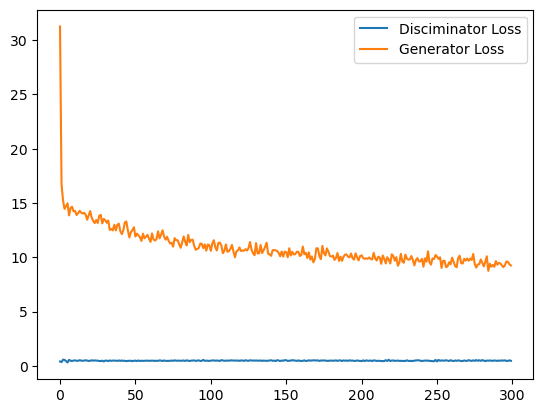

In [26]:
# Create loss curve for discriminator and generator
plt.plot(D_losses, label = "Disciminator Loss")
plt.plot(G_losses, label = "Generator Loss")
plt.legend()
plt.show()

In [27]:
with open("d_losses.txt", "w") as f:
    for idx, loss in enumerate(D_losses):
        f.write(f"{idx+1} {loss}\n")

with open("g_losses.txt", "w") as f:
    for idx, loss in enumerate(G_losses):
        f.write(f"{idx+1} {loss}\n")

In [28]:
from zipfile import ZipFile
import os

zipObj = ZipFile('results.zip', 'w')

for filename in os.listdir("/kaggle/working/results/"):
    if filename.endswith(".png"):
        zipObj.write("results/" + filename)

zipObj.close()

In [29]:
# Save the output in validation set
generator.eval()
idx = 0
for X,Y in tqdm(valloader):
    idx += 1
    X,Y = X.to(device), Y.to(device)

    with torch.no_grad():
        Y_fake = generator(X)
        Y_fake = Y_fake * 0.5 + 0.5 # remove normalization
        save_image(Y_fake, f"/kaggle/working/results/y_gen_final_{idx}.png")
        save_image(X * 0.5 + 0.5, f"/kaggle/working/results/input_final_{idx}.png")
        save_image(Y * 0.5 + 0.5, f"/kaggle/working/results/label_final_{idx}.png")

100%|██████████| 69/69 [02:04<00:00,  1.80s/it]
